In [1]:
# size of mote carlo sampling
sampSize = 10

In [2]:
%%time
from pycolator import *

idCol = 'SpecId'
scoreCol = 'NuXL:score'
excluded = ['SpecId', 'Label', 'ScanNr', 'Peptide', 'Proteins', 'FDR', 'q-val', 'class-specific_q-val', 'Rank', 'temp_score', 'percolator_score']

dSlow = readAndProcess('../data/1-AChernev_080219_dir_HeLa_cyt_UCGA_slow.tsv', idCol, scoreCol, excludedCols = excluded)
features = [x for x in list(dSlow.columns) if (x not in excluded)]

file read...
strings converted to floats...
q-values estimated...
ranks computed...
features normed...
floats converted to ints...
file ready!
Wall time: 24.7 s


In [12]:
# set up metrics of original data set

oriIdents = []
oriExpectIdents = []
oriLen = []
oriAUCs = []
dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1].copy()
dxl = addRanks(dxl, 'SpecId', 'NuXL:score')
    
for i in range(sampSize):
    expIdTemp = []
    lenTemp = []
    idTemp = []
    aucTemp = []
    for portion in range(12): # smallest df has 3 entries
        newDf = dxl.loc[dxl['class-specific_q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        expIdTemp.append(len(newDf.loc[newDf['class-specific_q-val'] <= 0.01]))
        
        newDf = calcQ(newDf, 'NuXL:score')
        try:
            aucTemp.append(pseudoROC(newDf, plot = False))
        except:
            aucTemp.append(0.0)
        lenTemp.append(len(newDf))
        idTemp.append(len(newDf.loc[newDf['q-val'] <= 0.01]))
    oriExpectIdents.append(expIdTemp)
    oriLen.append(lenTemp)
    oriIdents.append(idTemp)
    oriAUCs.append(aucTemp)

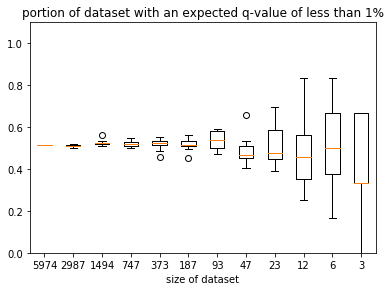

In [13]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_ylim(0,1.1)
x = range(1,13)

# for every sample round, for every dataset size, divide number of expected idents by the dataset size
l = [[e/l for e,l in zip(es,ls)] for es,ls in zip(oriExpectIdents,oriLen)]
# transpose for boxplots
y = list(map(list, zip(*l)))

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(oriLen[0])
plt.savefig('../results/ratioTests/boxplots/result_splitting_dxl.png')
plt.show()

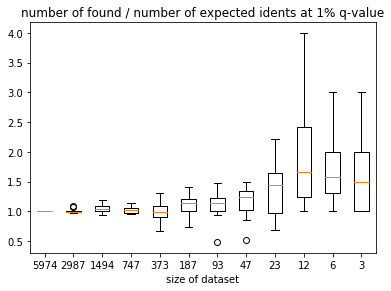

In [14]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
x = range(1,13)

# for every sample round, for every dataset size, divide number of idents by the number of expected idents, or 1 if we expect 0
l = [[i/e if (e != 0) else np.nan for i,e in zip(ils,es)] for ils,es in zip(oriIdents,oriExpectIdents)]
# transpose for boxplots
y = list(map(list, zip(*l)))
# remove nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(oriLen[0])
plt.savefig('../results/ratioTests/boxplots/found_vs_expected_dxl.png')
plt.show()

In [18]:
l12 = [li[9] for li in l]
l3 = [li[11] for li in l]
l3

[2.0, 1.5, 1.5, 3.0, nan, 1.0, nan, 1.0, 2.0, 1.0]

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2971, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3165, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3358, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 215.4779613134479.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3358, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3348, length of negative training set: 398
Optimal parameters are C=1 and class_

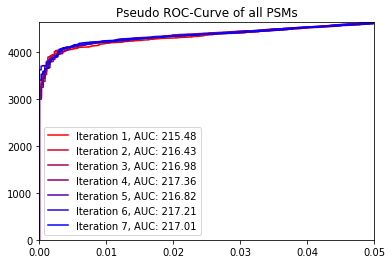

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1495, length of negative training set: 201
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1586, length of negative training set: 201
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1678, length of negative training set: 202
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 115.4360257632342.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1679, length of negative training set: 201
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1680, length of negative training set: 201
Optimal parameters are C=1 and c

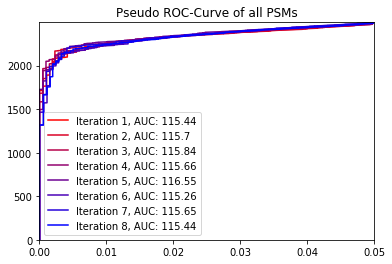

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 725, length of negative training set: 101
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 795, length of negative training set: 101
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 829, length of negative training set: 102
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.62417857795172.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 838, length of negative training set: 101
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 830, length of negative training set: 101
Optimal parameters are C=1 and class_weigh

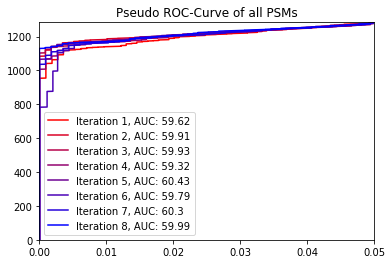

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 371, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 386, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 409, length of negative training set: 54
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.405482779330576.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 409, length of negative training set: 53
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 416, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0:

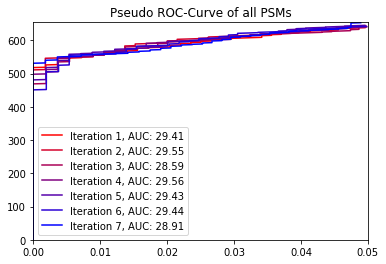

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 188, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 197, length of negative training set: 27
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 211, length of negative training set: 27
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.690615517244018.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 209, length of negative training set: 26
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 212, length of negative training set: 27
Optimal parameters are C=0.1 and class_we

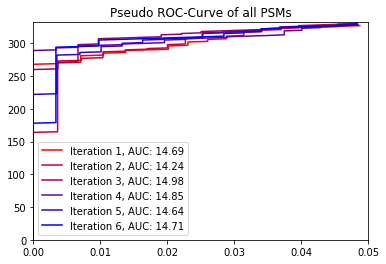

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 93, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 117, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.919836949777643.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 115, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 110, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 

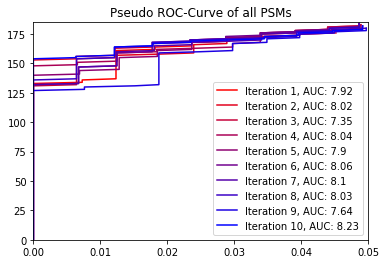

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 55, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 57, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.840621133894653.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 56, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 56, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Training in iteration 4 with split 3/3 starts!
Length of positive trainingset: 57, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Iteration 4/10 done! It yielded an auc of 3.8638769478481416.

Training in iteration 5 with split 1/3 starts!
Length of positive trainingset: 56, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 5 with split 2/3 starts!
Length of positive trainingset: 56, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 5 with split 3/3 starts!
Length of positive trainingset: 58, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Iteration 5/10 done! It yielded an auc of 3.83130119027238.

Training in iteration 6 with split 1/3 starts!
Length of positive trainingset: 57, length of negative training set: 4
Optimal parameters are C=0.1 and class_

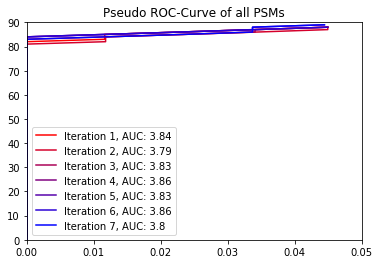

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2971, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3156, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3359, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.05989366073297.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3352, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3346, length of negative traini

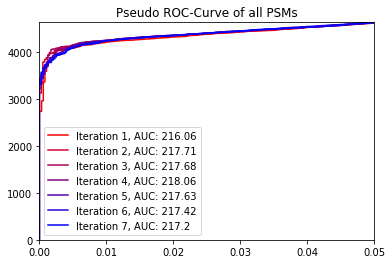

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1506, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1587, length of negative training set: 201
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1661, length of negative training set: 201
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 115.75758136693136.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1671, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1667, length of negative training set: 201
Optimal parameters are C=1 and c

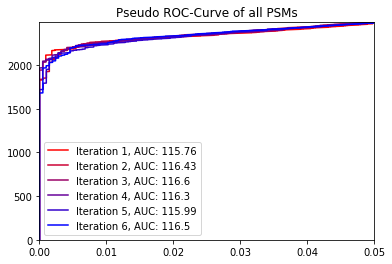

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 738, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 788, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 826, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.734874973515076.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 828, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 835, length of negative training set: 106
Optimal parameters are C=1 and class_we

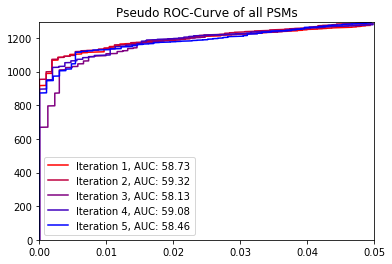

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 362, length of negative training set: 61
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 381, length of negative training set: 61
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 400, length of negative training set: 62
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.963391069486814.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 404, length of negative training set: 61
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 414, length of negative training set: 61
Optimal parameters are C=1 and class_weight={

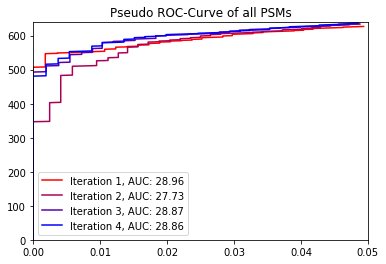

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 199, length of negative training set: 15
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 218, length of negative training set: 15
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 233, length of negative training set: 16
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.347527258160618.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 228, length of negative training set: 15
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 225, length of negative training set: 15
Optimal parameters are C=0.1 and class_we

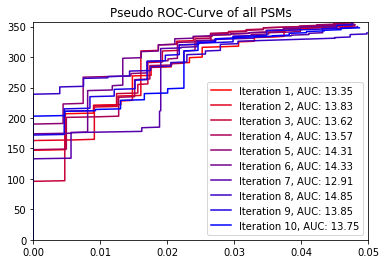

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 95, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 101, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 103, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.177690864245784.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 100, length of negative training set: 10
Optimal parameters are C=10 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 100, length of negative training set: 10
Optimal parameters are C=0.1 and class_w

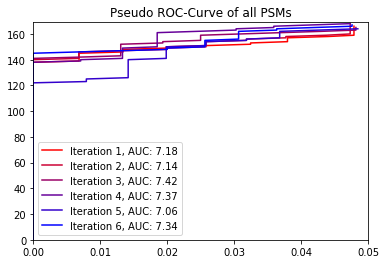

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 47, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 57, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.9546443814859926.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 52, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Training in iteration 3 with split 3/3 starts!
Length of positive trainingset: 52, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 3/10 done! It yielded an auc of 3.105462653288736.

Training in iteration 4 with split 1/3 starts!
Length of positive trainingset: 51, length of negative training set: 3
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 2/3 starts!
Length of positive trainingset: 49, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 3/3 starts!
Length of positive trainingset: 49, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Iteration 4/10 done! It yielded an auc of 2.507403948498736.

Training in iteration 5 with split 1/3 starts!
Length of positive trainingset: 42, length of negative training set: 3
Optimal parameters are C=0.1 and class_weigh

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 7/10 done! It yielded an auc of 3.195287269850983.

Training in iteration 8 with split 1/3 starts!
Length of positive trainingset: 52, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 8 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 8 with split 3/3 starts!
Length of positive trainingset: 50, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 8/10 done! It yielded an auc of 3.3900612483378305.

Training in iteration 9 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 9 with split 2/3 starts!
Length of positive trainingset: 51, length of negativ

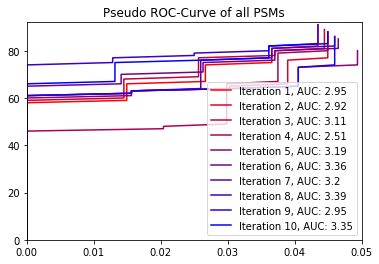

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3007, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3181, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3322, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 217.00377871979052.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3335, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3348, length of negative trai

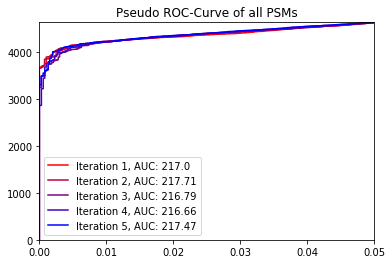

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1481, length of negative training set: 198
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1578, length of negative training set: 198
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1674, length of negative training set: 198
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.13628137606419.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1688, length of negative training set: 198
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1680, length of negative training set: 198
Optimal parameters are C=10 a

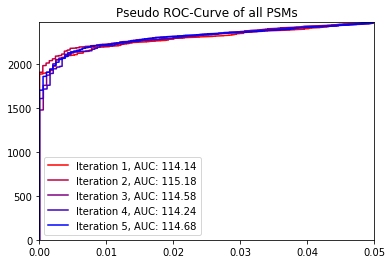

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 728, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 782, length of negative training set: 106
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 843, length of negative training set: 106
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.51631664603377.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 837, length of negative training set: 106
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 833, length of negative training set: 106
Optimal parameters are C=10 and class_weig

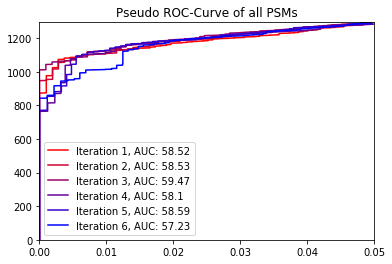

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 370, length of negative training set: 52
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 386, length of negative training set: 53
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 403, length of negative training set: 53
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 27.63422657778722.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 403, length of negative training set: 52
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 409, length of negative training set: 53
Optimal parameters are C=10 and class_weight={0:

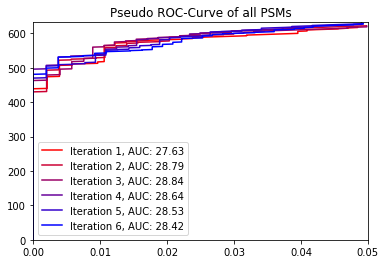

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 183, length of negative training set: 25
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 193, length of negative training set: 25
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 208, length of negative training set: 26
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.394267194470691.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 208, length of negative training set: 25
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 202, length of negative training set: 25
Optimal parameters are C=1 and class_weight={0

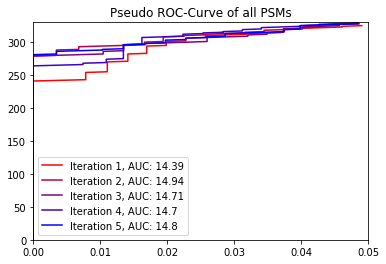

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 91, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 101, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 115, length of negative training set: 9
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.828020799618896.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 110, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 113, length of negative training set: 9
Optimal parameters are C=1 and class_weight={0: 

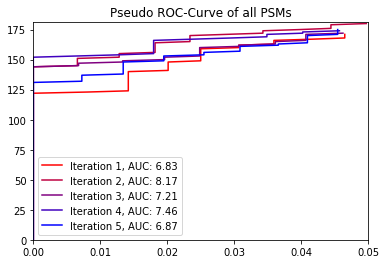

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 44, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 47, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 53, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.7083627503417116.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 51, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 53, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 

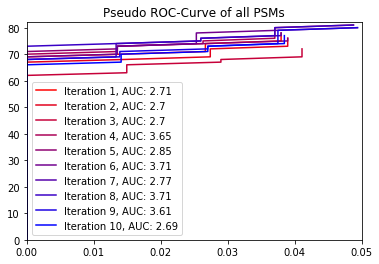

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3000, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3185, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3331, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 215.5173196305829.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3353, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3357, length of negative traini

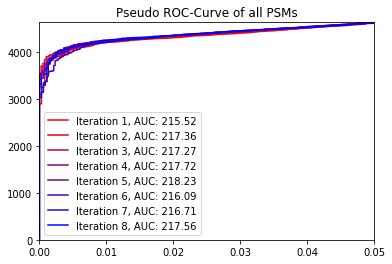

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1505, length of negative training set: 194
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1593, length of negative training set: 194
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1693, length of negative training set: 194
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.83963087749478.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1682, length of negative training set: 194
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1680, length of negative training set: 194
Optimal parameters are C=1 a

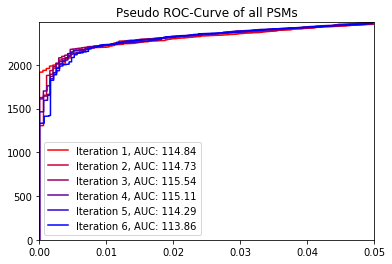

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 739, length of negative training set: 99
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 804, length of negative training set: 99
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 852, length of negative training set: 100
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.702097001927505.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 845, length of negative training set: 99
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 848, length of negative training set: 99
Optimal parameters are C=0.1 and class_weight

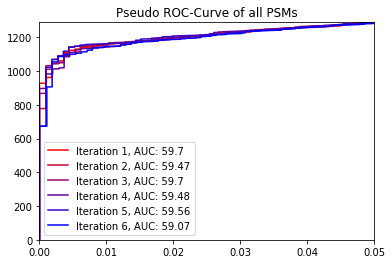

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 384, length of negative training set: 44
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 399, length of negative training set: 45
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 431, length of negative training set: 45
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 30.657052457095766.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 432, length of negative training set: 44
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 432, length of negative training set: 45
Optimal parameters are C=1 and class_weight=

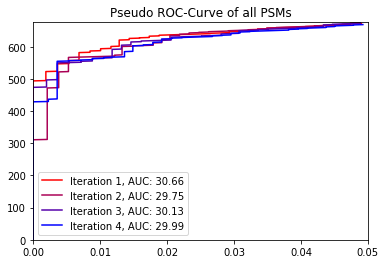

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 199, length of negative training set: 18
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 202, length of negative training set: 19
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 214, length of negative training set: 19
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.533605466228252.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 210, length of negative training set: 18
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 208, length of negative training set: 19
Optimal parameters are C=1 and class_weight={0

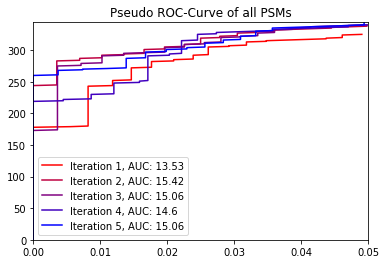

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 95, length of negative training set: 10
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 101, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 111, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.880849221386084.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 108, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 108, length of negative training set: 10
Optimal parameters are C=1 and class_weight=

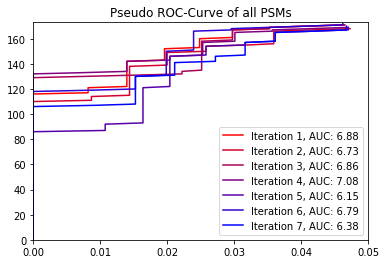

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 44, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 45, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 49, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.8785980286646495.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 52, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 3, 1:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Iteration 4/10 done! It yielded an auc of 3.713399734863153.

Training in iteration 5 with split 1/3 starts!
Length of positive trainingset: 50, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 5 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 5 with split 3/3 starts!
Length of positive trainingset: 52, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Iteration 5/10 done! It yielded an auc of 3.75449402226511.

Training in iteration 6 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 6 with split 2/3 starts!
Length of positive trainingset: 52, length of negative tr

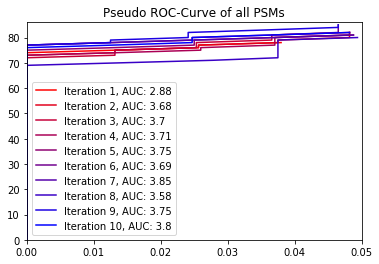

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2992, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3163, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3346, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.5903213552025.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3354, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3352, length of negative traini

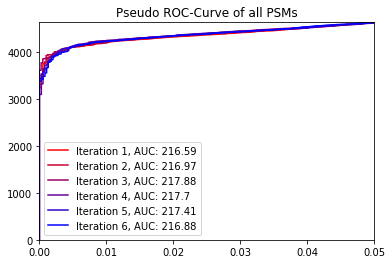

False
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1508, length of negative training set: 200
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1569, length of negative training set: 201
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1651, length of negative training set: 201
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.89610486232608.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1657, length of negative training set: 200
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1661, length of negative training set: 201
Optimal parameters are C=10 an

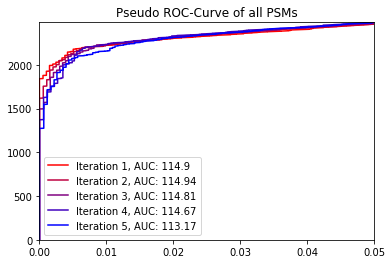

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 749, length of negative training set: 94
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 792, length of negative training set: 95
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 844, length of negative training set: 95
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.84007782522757.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 844, length of negative training set: 94
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 838, length of negative training set: 95
Optimal parameters are C=10 and class_weight={0

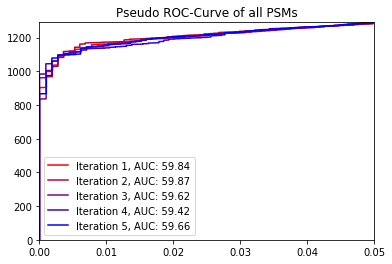

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 377, length of negative training set: 48
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 402, length of negative training set: 49
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 410, length of negative training set: 49
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 28.98726511150626.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 415, length of negative training set: 48
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 413, length of negative training set: 49
Optimal parameters are C=1 and class_weight=

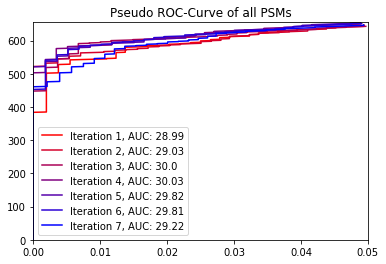

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 191, length of negative training set: 18
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 205, length of negative training set: 18
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 223, length of negative training set: 18
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.519213889529599.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 216, length of negative training set: 18
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 216, length of negative training set: 18
Optimal parameters are C=1 and class_weigh

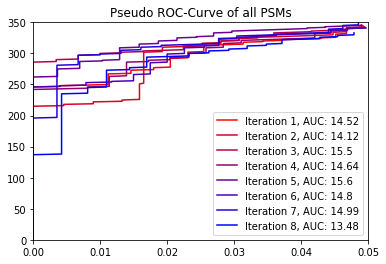

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 93, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 96, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 101, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 5.994408454647536.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 99, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 102, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0

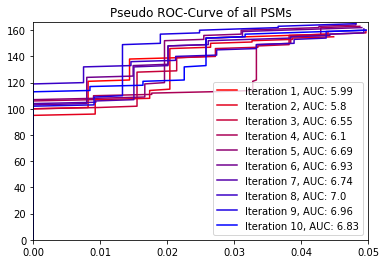

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 48, length of negative training set: 6
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 50, length of negative training set: 7
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 52, length of negative training set: 7
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.7019085327188117.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 52, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 52, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1:

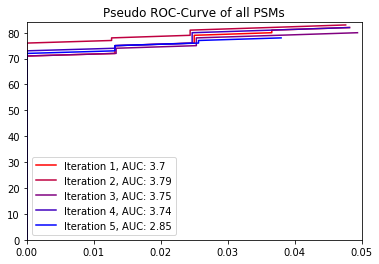

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2964, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3168, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3347, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.84772564829368.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3357, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3331, length of negative tra

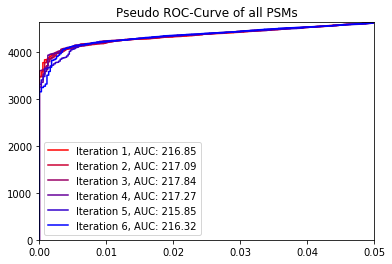

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1474, length of negative training set: 208
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1552, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1658, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 113.27062793223234.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1658, length of negative training set: 208
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1644, length of negative training set: 208
Optimal parameters are C=1 and c

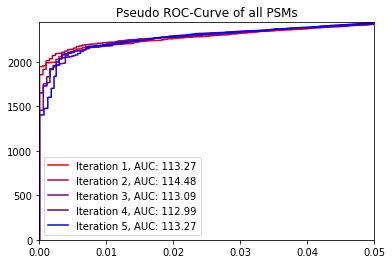

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 743, length of negative training set: 102
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 779, length of negative training set: 102
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 831, length of negative training set: 102
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 58.62589163785968.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 834, length of negative training set: 102
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 850, length of negative training set: 102
Optimal parameters are C=1 and class_weigh

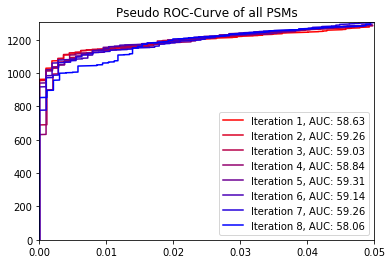

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 368, length of negative training set: 48
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 385, length of negative training set: 48
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 420, length of negative training set: 48
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.478082971912556.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 424, length of negative training set: 48
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 424, length of negative training set: 48
Optimal parameters are C=10 and class_weight=

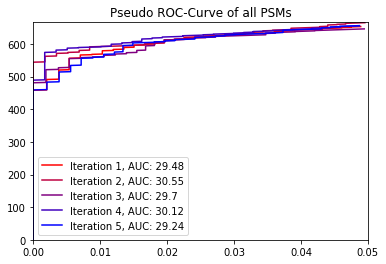

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 183, length of negative training set: 21
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 200, length of negative training set: 21
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 217, length of negative training set: 22
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.744879138931045.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 216, length of negative training set: 21
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 211, length of negative training set: 21
Optimal parameters are C=0.1 and class_weig

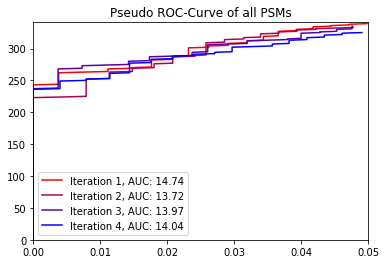

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 85, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 92, length of negative training set: 13
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 83, length of negative training set: 14
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 5.548274089941838.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 82, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 91, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight={0: 3

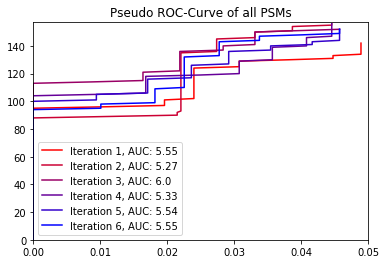

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 46, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 50, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 55, length of negative training set: 7
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.7815831001993416.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 54, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 50, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 

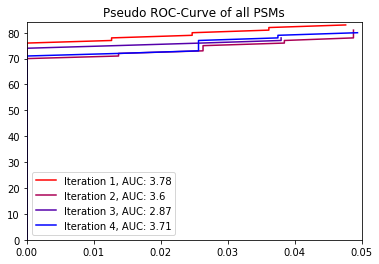

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 24, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 15, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 11, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 0.9000000000000008.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 17, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 21, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3

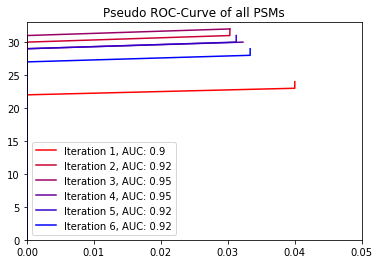

Dataset too small: 23 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3011, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3179, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3329, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.91492844516804.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3340, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3337, length of negative trai

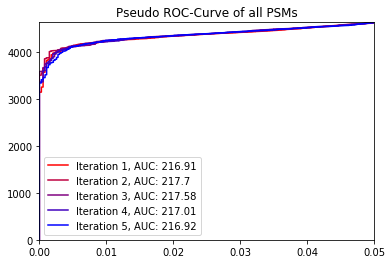

False
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1478, length of negative training set: 212
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1537, length of negative training set: 213
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1629, length of negative training set: 213
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 114.19602175281588.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1656, length of negative training set: 212
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1653, length of negative training set: 213
Optimal parameters are C=1 an

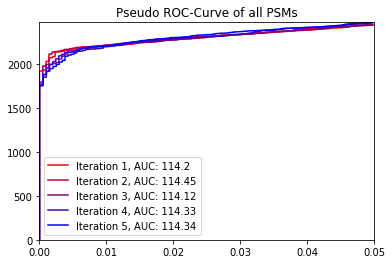

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 742, length of negative training set: 98
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 794, length of negative training set: 98
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 834, length of negative training set: 98
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.293158937470366.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 838, length of negative training set: 98
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 835, length of negative training set: 98
Optimal parameters are C=1 and class_weigh

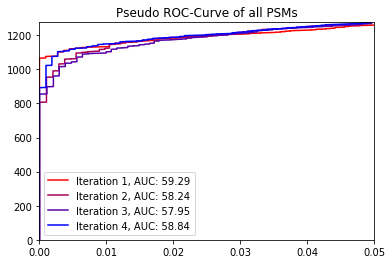

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 374, length of negative training set: 49
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 384, length of negative training set: 49
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 416, length of negative training set: 50
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.63946033374538.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 408, length of negative training set: 49
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 416, length of negative training set: 49
Optimal parameters are C=0.1 and class_weight

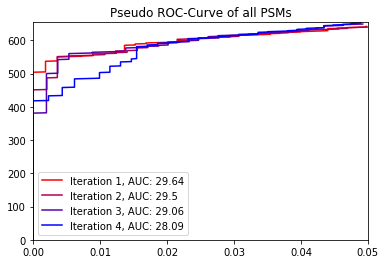

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 186, length of negative training set: 21
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 190, length of negative training set: 21
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 210, length of negative training set: 22
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.803300181496438.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 211, length of negative training set: 21
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 212, length of negative training set: 21
Optimal parameters are C=1 and class_weight={

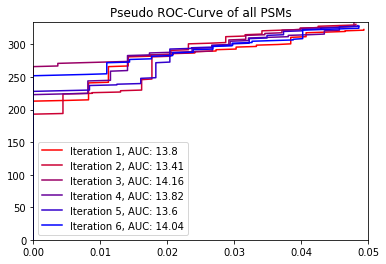

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 89, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 86, length of negative training set: 13
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 94, length of negative training set: 14
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.029272349588068.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 92, length of negative training set: 13
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 97, length of negative training set: 13
Optimal parameters are C=10 and class_weight={0:

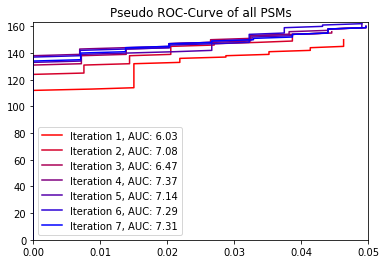

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 43, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 48, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 53, length of negative training set: 9
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.901909318751425.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 49, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 9
Optimal parameters are C=10 and class_weight={0: 3

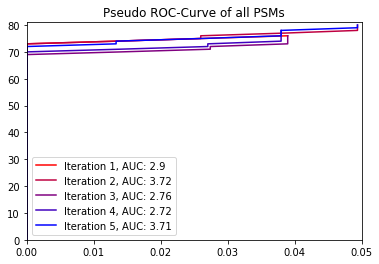

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 23, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 24, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 24, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 0.9594594594594575.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 27, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 20, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Iteration 4/10 done! It yielded an auc of 0.9324324324324306.

Results are not getting better. Terminating and using Iteration 1 with an auc of 0.96.


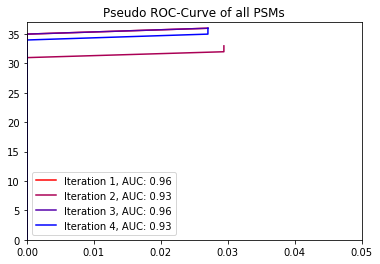

Dataset too small: 23 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3000, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3158, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3349, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.75933638521886.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3355, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3346, length of negative train

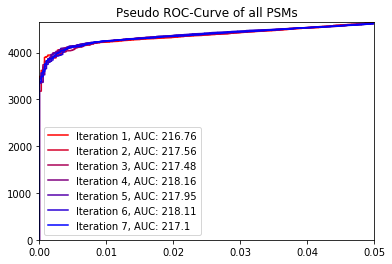

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1494, length of negative training set: 192
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1568, length of negative training set: 192
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1666, length of negative training set: 192
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 115.10900645534652.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1686, length of negative training set: 192
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1685, length of negative training set: 192
Optimal parameters are C=1 and

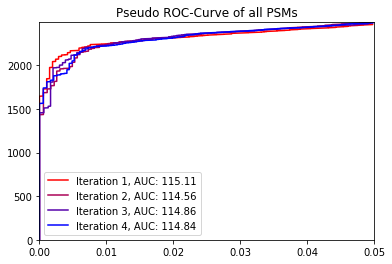

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 752, length of negative training set: 96
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 809, length of negative training set: 97
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 857, length of negative training set: 97
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 59.37446041731865.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 852, length of negative training set: 96
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 854, length of negative training set: 97
Optimal parameters are C=10 and class_weight=

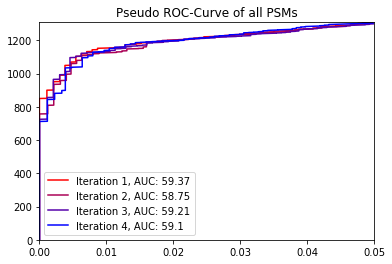

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 371, length of negative training set: 54
Optimal parameters are C=10 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 388, length of negative training set: 55
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 405, length of negative training set: 55
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 27.476214551224288.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 415, length of negative training set: 54
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 410, length of negative training set: 55
Optimal parameters are C=1 and class_weight=

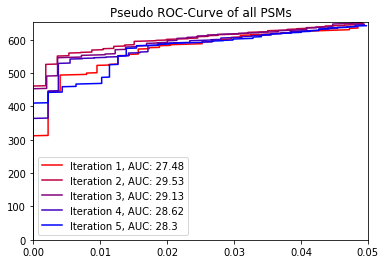

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 175, length of negative training set: 32
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 185, length of negative training set: 32
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 193, length of negative training set: 32
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.227449426241847.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 193, length of negative training set: 32
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 196, length of negative training set: 32
Optimal parameters are C=1 and class_wei

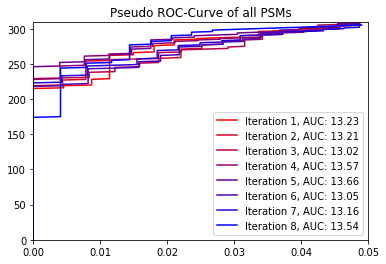

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 98, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 100, length of negative training set: 12
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 108, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.574132944827392.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 107, length of negative training set: 12
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 102, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight=

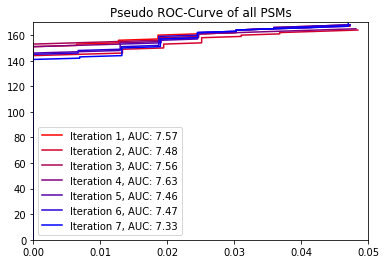

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 44, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 48, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 50, length of negative training set: 8
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 2.8035225048923706.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 49, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 49, length of negative training set: 7
Optimal parameters are C=0.1 and class_weight={0:

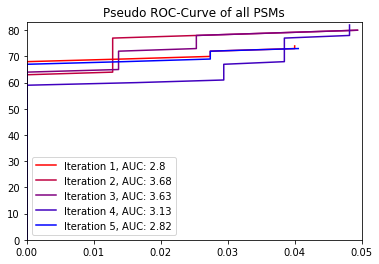

Dataset too small: 47 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 3004, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3177, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3361, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 215.90801910736818.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3339, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3358, length of negative trai

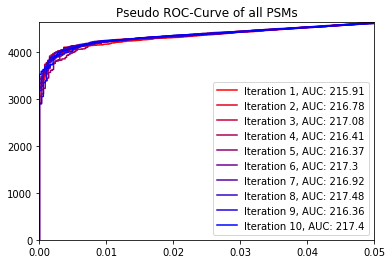

False
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1492, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1592, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1696, length of negative training set: 190
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 117.94688380227399.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1704, length of negative training set: 189
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1711, length of negative training set: 189
Optimal parameters are C=10 

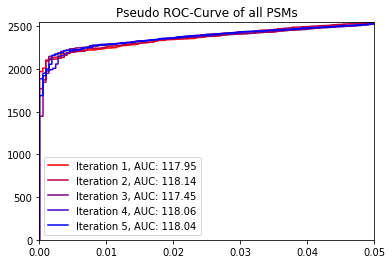

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 736, length of negative training set: 91
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 789, length of negative training set: 91
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 848, length of negative training set: 92
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 60.48518506292591.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 844, length of negative training set: 91
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 843, length of negative training set: 91
Optimal parameters are C=1 and class_weight

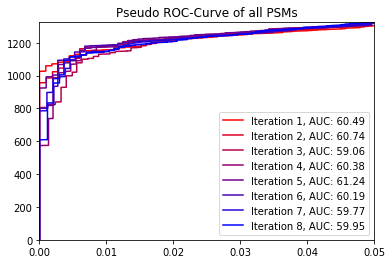

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 374, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 398, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 417, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.37683101589831.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 421, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 416, length of negative training set: 56
Optimal parameters are C=1 and class_weight={0: 1

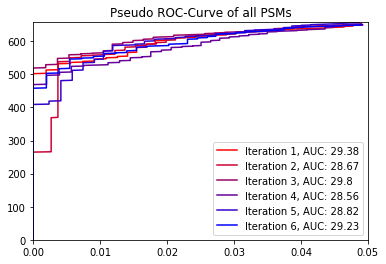

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 190, length of negative training set: 24
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 193, length of negative training set: 25
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 203, length of negative training set: 25
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 13.788646036569407.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 208, length of negative training set: 24
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 205, length of negative training set: 25
Optimal parameters are C=0.1 and class_weigh

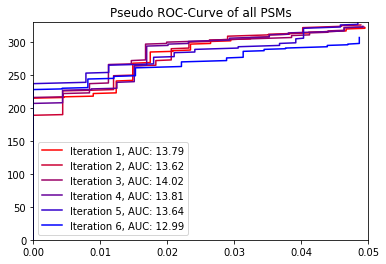

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 91, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 104, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 103, length of negative training set: 12
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 7.1741139704385635.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 104, length of negative training set: 12
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 107, length of negative training set: 12
Optimal parameters are C=1 and class_weight={

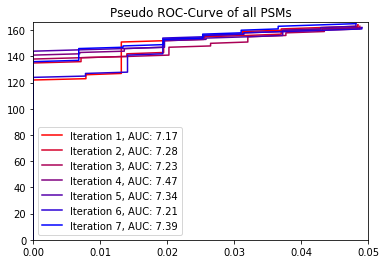

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 46, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 46, length of negative training set: 5
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 55, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.747427875058344.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 54, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 5
Optimal parameters are C=0.1 and class_weight={0: 3,

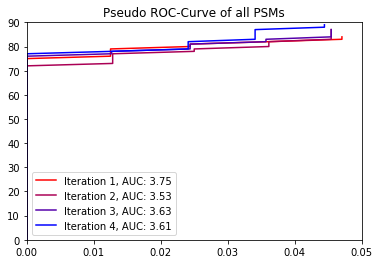

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 25, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 24, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 23, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 1.8076923076923097.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 26, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 24, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_classes.py", line 237, in fit
    self.loss, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 928, in _fit_liblinear
    " class: %r" % classes_[0])
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for th

Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 4 with split 2/3 starts!
Length of positive trainingset: 26, length of negative training set: 3
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 4 with split 3/3 starts!
Length of positive trainingset: 20, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Iteration 4/10 done! It yielded an auc of 0.8815789473684201.

Results are not getting better. Terminating and using Iteration 1 with an auc of 1.81.


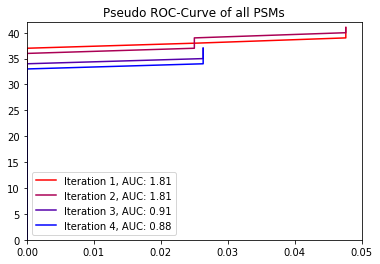

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 11, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 11, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 7, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using identifications at 1% q-value with rank 1 as metric.
Iteration 1/10 done! It yielded identifications of 12.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 8, length of negative training set: 4
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 7, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 1, 1: 

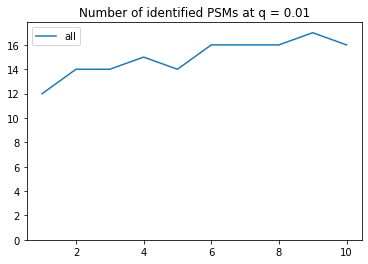

Dataset too small: 12 PSMs. Quitting evaluation.
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 2963, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 3140, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 3333, length of negative training set: 398
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 216.42987398394487.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 3335, length of negative training set: 398
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 3335, length of negative traini

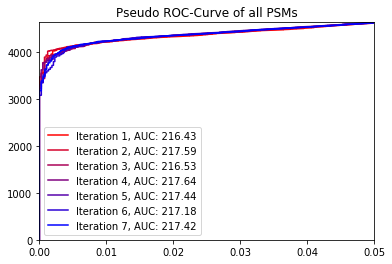

True
Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 1512, length of negative training set: 192
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 1585, length of negative training set: 192
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 1685, length of negative training set: 192
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 116.73752007793205.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 1689, length of negative training set: 192
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 1697, length of negative training set: 192
Optimal parameters are C=0.1 a

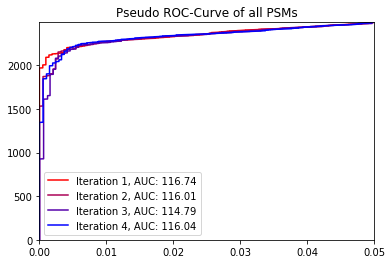

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 741, length of negative training set: 90
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 800, length of negative training set: 91
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 864, length of negative training set: 91
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 60.1770885291669.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 866, length of negative training set: 90
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 861, length of negative training set: 91
Optimal parameters are C=0.1 and class_weig

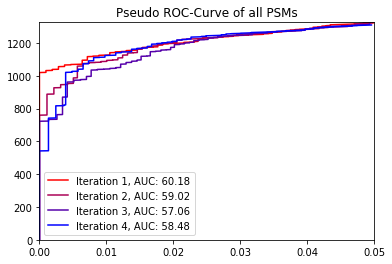

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 371, length of negative training set: 46
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 398, length of negative training set: 47
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 426, length of negative training set: 47
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 29.420885108756764.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 417, length of negative training set: 46
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 420, length of negative training set: 47
Optimal parameters are C=1 and class_weigh

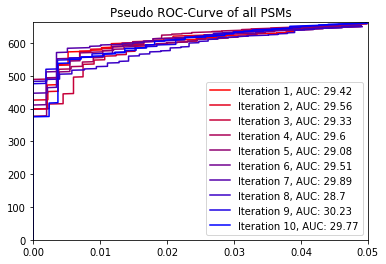

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 189, length of negative training set: 24
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 196, length of negative training set: 25
Optimal parameters are C=10 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 209, length of negative training set: 25
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 14.192256779658202.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 205, length of negative training set: 24
Optimal parameters are C=1 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 203, length of negative training set: 25
Optimal parameters are C=0.1 and class_weig

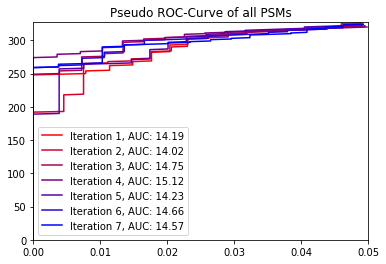

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 91, length of negative training set: 10
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 93, length of negative training set: 11
Optimal parameters are C=10 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 90, length of negative training set: 11
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 6.562839762355426.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 95, length of negative training set: 10
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 98, length of negative training set: 11
Optimal parameters are C=1 and class_weight={0: 1, 

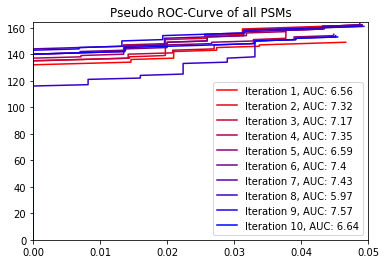

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 47, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 3, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 51, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 51, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 3.791719598845668.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 53, length of negative training set: 6
Optimal parameters are C=0.1 and class_weight={0: 10, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 53, length of negative training set: 6
Optimal parameters are C=1 and class_weight={0: 1, 1:

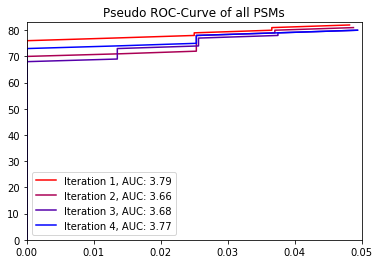

Training in iteration 1 with split 1/3 starts!
Length of positive trainingset: 24, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 2/3 starts!
Length of positive trainingset: 25, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1, 1: 1}.

Training in iteration 1 with split 3/3 starts!
Length of positive trainingset: 21, length of negative training set: 4
Optimal parameters are C=1 and class_weight={0: 1, 1: 1}.

Using AUC of pseudo-ROC with x = [0,0.05] as metric.
Iteration 1/10 done! It yielded an auc of 1.7039295392953944.

Training in iteration 2 with split 1/3 starts!
Length of positive trainingset: 27, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 3, 1: 1}.

Training in iteration 2 with split 2/3 starts!
Length of positive trainingset: 24, length of negative training set: 3
Optimal parameters are C=0.1 and class_weight={0: 1,

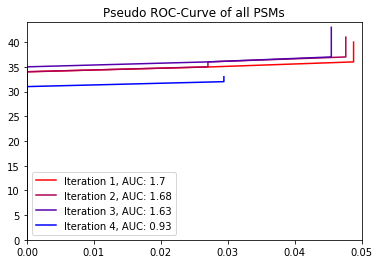

Dataset too small: 23 PSMs. Quitting evaluation.
Wall time: 10min 9s


In [6]:
%%time
# calculate metrics of percolator results

# expected idents if algorithm would work as well as NuXL:score
expId = []

# expected idents if the algorithm would work as well as with the whole data set
pExpectIdents = []

pIdents = []
pLen = []
pAUCs = []

# With which portion the algorithm terminated
pAbort = []

saveName = ''

iters = 12 # smallest df has 3 entries
for i in range(sampSize):
    stdExpIdTemp = []
    expIdTemp = []
    idTemp = []
    lenTemp = []
    aucTemp = []
    
    for portion in range(iters):
        dxl = dSlow.loc[dSlow['NuXL:isXL'] == 1].copy()
        dxl = addRanks(dxl, 'SpecId', 'NuXL:score')

        newDf = dxl.loc[dxl['class-specific_q-val'] <= 0.1].sample(frac = 1/pow(2,portion))
        stdExpIdTemp.append(len(newDf.loc[(newDf['class-specific_q-val'] <= 0.01) & (newDf['Rank'] == 1)]))
        newIx = newDf.index

        try:
            pxl = percolator_experimental(newDf, idCol, features, plotSaveName = saveName, plotXLnXL = False)
        except:
            print('Dataset too small: {} PSMs. Quitting evaluation.'.format(len(newDf)))
            del stdExpIdTemp[-1]
            break

        if (portion == 0):
            print(all(pxl['q-val'] == pxl['class-specific_q-val']))
            fullP = pxl.loc[:,['Label', 'percolator_score', 'q-val']].copy()

        # maybe calc Q with sampled subset of fullP?
        expIdTemp.append(len(fullP.loc[(fullP.index.isin(newIx)) & (fullP['q-val'] <= 0.01)]))

        try:
            aucTemp.append(pseudoROC(pxl, plot = False))
        except:
            print('Error while calculating AUC in iteration {}/{}!'.format(portion + 1, iters))
            aucTemp.append(0.0)
        lenTemp.append(len(pxl))
        idTemp.append(len(pxl.loc[pxl['q-val'] <= 0.01]))
        
    pAbort.append(portion)
    expId.append(stdExpIdTemp)
    pExpectIdents.append(expIdTemp)
    pLen.append(lenTemp)
    pIdents.append(idTemp)
    pAUCs.append(aucTemp)

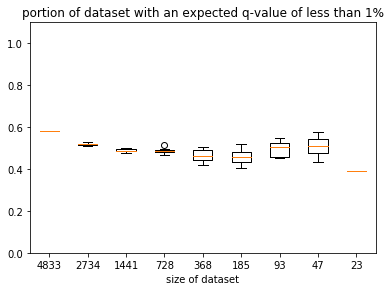

In [7]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_ylim(0,1.1)
x = range(1,max(pAbort) + 1)

# for every sample round, for every dataset size, divide number of expected idents by the dataset size
l = [[e/l for e,l in zip(es,ls)] for es,ls in zip(expId,pLen)]
# for missing iterations, fill in nan
for k in l:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
# transpose for boxplots
y = list(map(list, zip(*l)))
# filter nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('portion of dataset with an expected q-value of less than 1%')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/result_splitting_pxl.png')
plt.show()

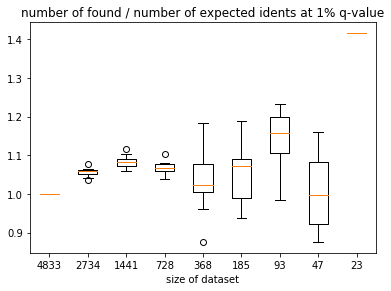

In [9]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
x = range(1,max(pAbort) + 1)

# for every sample round, for every dataset size, divide number of idents by the number of expected idents, or 1 if we expect 0
l = [[i/e if (e != 0) else np.nan for i,e in zip(ils,es)] for ils,es in zip(pIdents,pExpectIdents)]
# for missing iterations, fill in nan
for k in l:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
# transpose for boxplots
y = list(map(list, zip(*l)))
# remove nan for boxplot
y = [[i for i in ls if not np.isnan(i)] for ls in y]

ax.boxplot(y)
ax.set_xlabel('size of dataset')
ax.set_title('number of found / number of expected idents at 1% q-value')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/found_vs_expected_pxl.png')
plt.show()

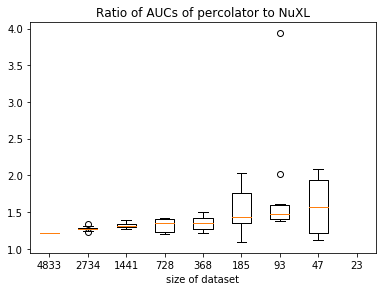

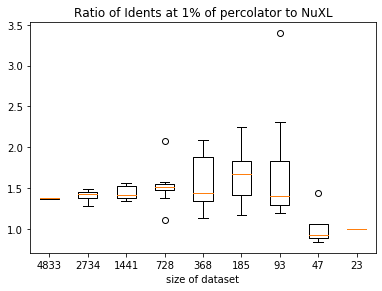

In [10]:
x = range(1,max(pAbort) + 1)

# for every sample round, for every dataset size, divide percolator result by original result
ratioAUCs = [[p/o if (o != 0) else np.nan for p,o in zip(ps,os)] for ps,os in zip(pAUCs,oriAUCs)]
ratioIdents = [[p/o if (o != 0) else np.nan for p,o in zip(ps,os)] for ps,os in zip(pIdents,oriIdents)]

# for missing iterations, fill in nan
for k in ratioAUCs:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
for k in ratioIdents:
    while(len(k) != max(pAbort)):
        k.append(np.nan)
        
# transpose for boxplots
yAUC = list(map(list, zip(*ratioAUCs)))
yIdents = list(map(list, zip(*ratioIdents)))

# remove nan for boxplot
yAUC = [[i for i in ls if not np.isnan(i)] for ls in yAUC]
yIdents = [[i for i in ls if not np.isnan(i)] for ls in yIdents]

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yAUC)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of AUCs of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/auc_p_vs_ori.png')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yIdents)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of Idents at 1% of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/idents_p_vs_ori.png')
plt.show()

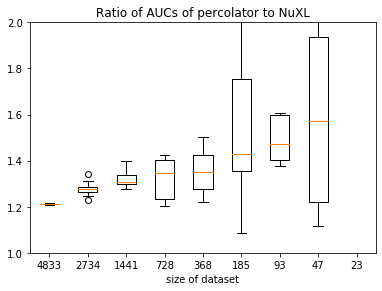

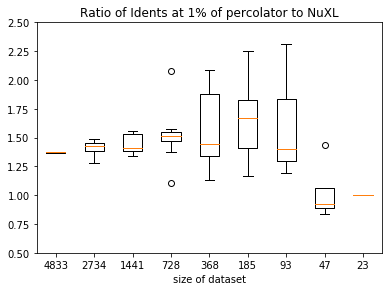

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yAUC)
ax.set_ylim(1,2)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of AUCs of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/auc_p_vs_ori_zoomed.png')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.boxplot(yIdents)
ax.set_ylim(0.5,2.5)
ax.set_xlabel('size of dataset')
ax.set_title('Ratio of Idents at 1% of percolator to NuXL')
ax.set_xticks(x)
ax.set_xticklabels(pLen[np.argmax(pAbort)])
plt.savefig('../results/ratioTests/boxplots/idents_p_vs_ori_zoomed.png')
plt.show()